# AuxTel data reduction pipeline


Author: **Chris Suberlak** ([@suberlak](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@suberlak))
<br>Last Verified to Run: **2022-04-22**
<br>Software Versions:
  - `ts_wep`: **v2.3.0**
  - `lsst_distrib`: **w_2022_12**
  
## Goal
Take raw auxTel images, run ISR, and pass through the AOS pipeline to recover Zernikes. We explore two options: viability of using the WCS information attached to the in-focus exposure to arrive at donut catalog, and using donut template fitting with the defocal exposure to arrive at donut catalog.  


## Setup:
    
   * access to NCSA lsst-devl nodes 
   * working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) for additional info on how to install and build the AOS packages)
    
It is assumed that `ts_analysis_notebooks` resides in `$PATH_TO_TS_ANALYSIS_NOTEBOOKS`. Here it was `/project/scichris/aos/ts_analysis_notebooks`.

At least once after cloning the `ts_analysis_notebooks` repo one needs to run the `setup` and `scons` commands. It can be  for example:
   
    cd $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    setup -k -r .
    scons 

### Option A : using LSP 

After authenticating VPN, and opening a new machine on https://lsst-lsp-stable.ncsa.illinois.edu/ one can run this notebook on LSP, assuming that `lsst_distrib`, `ts_wep` and `ts_analysis_notebooks`  have been setup (for terminal commands such as pipetask), and same commands were added to the  `${HOME}/notebooks/.user_setups`  file that is sourced when starting the `LSST` jupyter kernel, for instance:
    
    setup lsst_distrib
    setup ts_wep -t $USER  -k -r /project/scichris/aos/ts_wep/
    setup ts_analysis_notebooks -k -r 
    
### Option B: tunneling jupyter notebook to a browser via SSH

Setup (that was used to run the analysis on a notebook opened in a browser using an ssh connection to the NCSA machine). Here `scichris` is my username, and `/project/scichris/aos/setup_aos_current.sh` the setup script that loads the AOS packages. In particular, the `ts_wep` installation used was `/project/scichris/aos/ts_wep` . The `54467` can be any other port number, as long as it is consistent between `ssh` connection and the jupyter notebook.
    
Run in the terminal on the local machine:

    ssh -L 54467:localhost:54467 scichris@lsst-devl02
    
Run in the NCSA terminal after DUO authentication (I aliased these in `~/.bash_profile`:

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib     # first two aliased with "lsst"
    
    source /project/scichris/aos/setup_aos_current.sh  # aliased as "aos"
    
    setup -k -r $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    
    jupyter notebook --no-browser --port=54467         # aliased as "jup" 
   
This should open the browser at the NCSA `/jhome` directory.  I navigate to `$PATH_TO_TS_ANALYSIS_NOTEBOOKS` to open this notebook.




## Imports

In [2]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import astropy.units as u

import matplotlib.pyplot as plt
import numpy as np 
from lsst.daf import butler as dafButler
from lsst.daf.persistence import Butler
import lsst.geom
import lsst.utils.tests
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.afw.image import FilterLabel
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay

from matplotlib import rcParams 

from copy import copy
from copy import deepcopy
import yaml

from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
)
from lsst.ts.wep.task.EstimateZernikesLatissTask import (
    EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
)

from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface

from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (
    GenerateDonutCatalogWcsTask, GenerateDonutCatalogWcsTaskConfig)

from lsst.ts.analysis.notebooks import plotting_tools as pt


In [3]:
rcParams['ytick.labelsize'] = 13
rcParams['xtick.labelsize'] = 13
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 15

# Contents:<a id='toc'></a>

 * [1 Workflow with three images, updating the out-of-focus WCS from sources in the in-focus image](#WCS)
   * [1.1 Load the raws](#raws)
   * [1.2 Run the ISR](#isr)
   * [1.3 Get sources for AOS pipeline from the in-focus exposure](#sources)
     * [1.3.1 Illustrate the location of sources given the original WCS](#originalWcs)
     * [1.3.2 Correct WCS with source detection task  and run astrometry task ](#detection)
   * [1.4 Run Zernike estimation](#zernikes)
  
 * [2 Workflow with two defocal images using donut template fitting](#template)
   * [2.1 Load the raw defocal images, do the ISR](#loadDefocal)
   * [2.2 Find sources with donut template fitting and run Zernike estimation](#fitDonuts)
 * [3 Everything as a pipetask](#pipetask)
 * [4 Summary](#summary)
 
  
  

# 1 Example workflow using updated WCS information <a id='wcs'></a>

## 1.1 Load the raws and ensure that there are intra, extra, and in-focus images <a id='raws'></a>

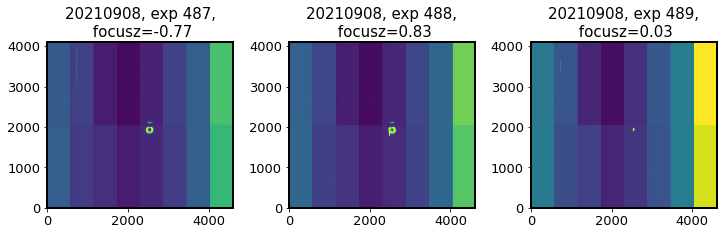

In [24]:
pt.preview_exposures(year_month_day='20210908', exp_start=487, exp_end=490,
                    dataset_ref_or_type='raw',
                    collection="LATISS/raw/all")

## 1.2 Run the ISR <a id='isr'></a>
[Go to table of contents](#toc)


To run the ISR we make a `testLatiss.yaml` config file. It should contain the following:

     description: ISR basic processing pipeline
        instrument: lsst.obs.lsst.Latiss
        tasks:
          isr:
            class: lsst.ip.isr.isrTask.IsrTask
            config:
              connections.outputExposure: postISRCCD
              doApplyGains: false
              doBias: true
              doBrighterFatter: false
              doCrosstalk: false
              doDark: true
              doDefect: false
              doFlat: true
              doFringe: true
              doInterpolate: true
              doLinearize: false
              doNanMasking: false
              doOverscan: true
              doVariance: false
              python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'
              
an example including the  correct spacing (which is important) is available at `/project/scichris/aos/testLatiss4.yaml`. Assuming that the file is at `/project/$USER/testLatiss.yaml`,  putting the output to `u/$USER/Latiss/postISR/` collection, the command to run the `pipetask` is : 
    
    pipetask run  --data-query "exposure IN (2021090800487..2021090800489) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib --output u/$USER/Latiss/postISR --pipeline /project/$USER/testLatiss.yaml  --register-dataset-types

Show the result of running the ISR:

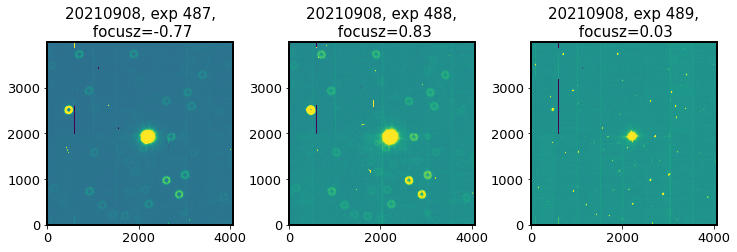

In [6]:
%matplotlib inline
pt.preview_exposures(year_month_day='20210908', exp_start=487, exp_end=490,
                    dataset_ref_or_type='postISRCCD',
                    collection='u/scichris/Latiss/postISRex')

## 1.3 Get sources for AOS pipeline from the in-focus exposure <a id='sources'></a>
[Go to table of contents](#toc)

## 1.3.1 Illustrate the location of sources given the original WCS <a id='originalWcs'></a>
[Go to table of contents](#toc)

Now the expected problem for some auxTel images was that the WCS attached to the exposure is 180 degree + several pixels off. Illustrate that by plotting the GAIA source catalog given the original WCS as well as rotated WCS:

In [7]:
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRex'])


I load the sources from the reference catalog using the `ts_wep`  `GenerateDonutCatalogWcsTask` : 

In [8]:
# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

# Load the ts_wep RefCatalogInterface
refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

htmIds = refCatInterface.getHtmIds()

butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)


# instantiate the task with the appropriate config 
donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'
donutCatConfig.donutSelector.fluxField = 'phot_g_mean_flux'

donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }

#Get the sources from reference catalog assuming the original WCS
originalWcs = postIsr.getWcs()
originalDonutCatStruct = donutCatTask.run(dataRefs, postIsr, )

#Make magnitude cuts for cleaner illustration
originalCatalog  = originalDonutCatStruct.donutCatalog

mag_list = (originalCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

originalCatalog['mags'] = mag_array
mask = mag_array<16
originalCatalogMagCut = originalCatalog[mask]

Plot the postISR image with GAIA sources given the original WCS (yellow):

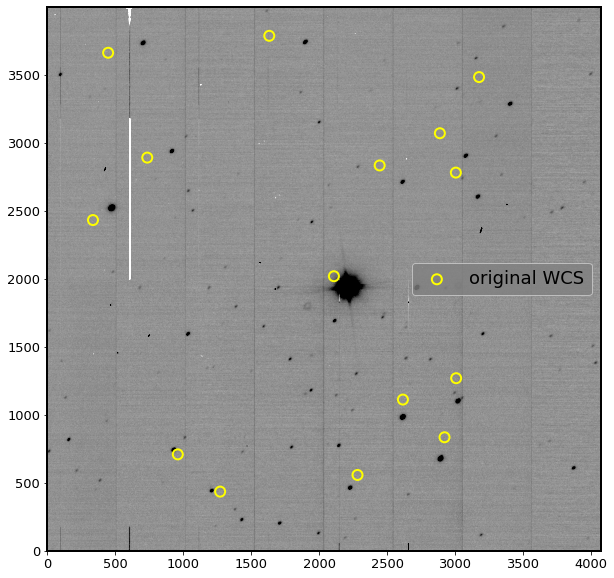

In [9]:
%matplotlib inline

zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = originalCatalogMagCut
color = 'yellow'
lw=2
label='original WCS'
ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

We see that the original WCS attached to auxTel exposure is several tens of pixels + several degrees of rotation off. This is too much of a difference  as an initial guess for astrometry task (see details in https://sitcomtn-038.lsst.io/), so we run the source detection task first.

## 1.3.2 Correct WCS with source detection task  and run astrometry task <a id='detection'></a>
[Go to table of contents](#toc)

Here I convolve the image with Gaussian PSF to detect sources, and use that as an input for astrometry task. This approach could be turned to `ts_wep` task if needed, but it would require three exposures (one in-focus to detect sources, and two defocal, at the ~exact same position).

In [10]:
# Read the exposure again
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRex'])

In [11]:
def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

Illustrate the kernel:

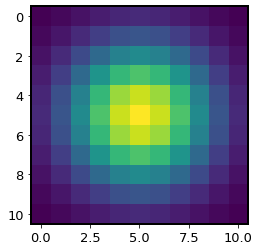

In [12]:
psf_array = gkern(l=11, sig=2.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)
plt.imshow(psf_image.array)

postIsr.setPsf(psf)

Run the `SourceDetectionTask`:

In [13]:
#Use DM tasks to run: detection, measure using the simple PSF (no deblending)

schema = lsst.afw.table.SourceTable.makeMinimalSchema()

configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue = 30  # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"   # units for thresholdValue
configDetection.includeThresholdMultiplier = 1.0 
configDetection.minPixels = 500
#configDetection.charImage.background.weighting = False  
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)


measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table

#create copy of image to explicitly set the PSF
exposure = deepcopy(postIsr)
exposure.setPsf(psf)

# Run the detect the measure tasks
detect_result = detect.run(table, exposure,)# weighing=False)

catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(catalog, exposure)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gf36ae6ace1+1d7ae49801/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gf36ae6ace1+1d7ae49801/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Plot the resulting source catalog:

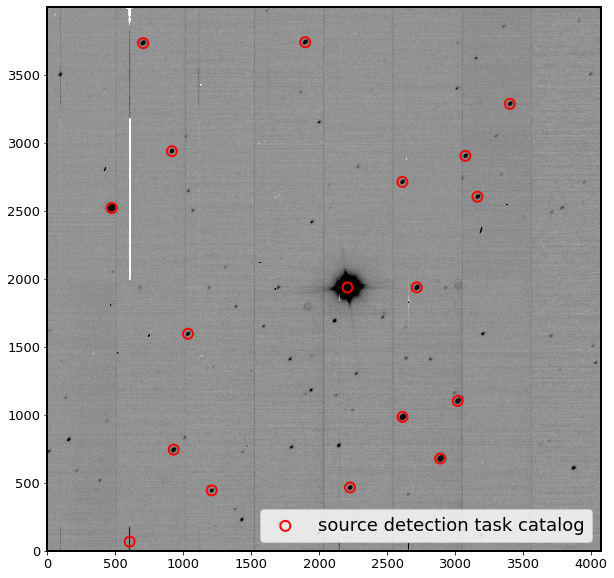

In [18]:
%matplotlib inline
zscale = ZScaleInterval()
data = postIsr.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(catalog['slot_Centroid_x'], catalog['slot_Centroid_y'],s=100,facecolors='none', edgecolors='red',
          lw=2 , label='source detection task catalog')
ax.legend(fontsize=18)

We see that this nicely detected sources (setting threshold to $30 \sigma$ ignored fainter stars which is fine, since not all sources are needed to do astrometry).

Use that source catalog as an input for `AstrometryTask` fit:

In [19]:
# As above, I'm forcing the exposure
# to have the same name as the one in the Gaia catalog for now
postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

# Load the ts_wep RefCatalogInterface
refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

htmIds = refCatInterface.getHtmIds()


butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)


donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'
donutCatConfig.donutSelector.fluxField = 'phot_g_mean_flux'

# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }

# store the unchanged WCS in a variable to compare to the changes done 
# by running astrometry fit 
originalWcs = postIsr.getWcs()

astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.999
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15

schema = lsst.afw.table.SourceTable.makeMinimalSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
results = solver.run(sourceCat=catalog, exposure=postIsr,)

Running the astrometry task updates the WCS attached to the postIsr exposure. Compare the original and updated WCS:

In [20]:
originalWcs

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [21]:
postIsr.getWcs()

FITS standard SkyWcs:
Sky Origin: (306.9575674280, -87.4684455328)
Pixel Origin: (1930.01, 1989.89)
Pixel Scale: 0.0957529 arcsec/pixel

We see that they are different! Given that updated WCS, we can pull sources from the reference catalog, to make sure that astrometry arrived at a correct solution:

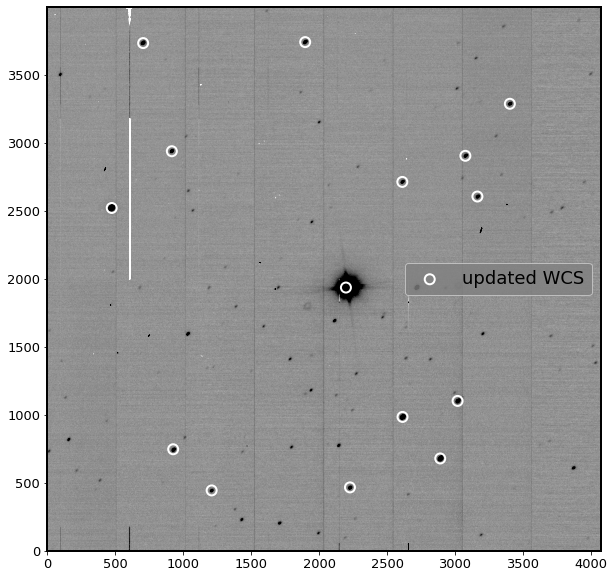

In [23]:
%matplotlib inline

updatedDonutCat =  donutCatTask.run(dataRefs, postIsr, )
updatedCatalog  = updatedDonutCat.donutCatalog

mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

updatedCatalog['mags'] = mag_array
mask = mag_array<16
updatedCatalogMagCut = updatedCatalog[mask]


zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = updatedCatalogMagCut
color = 'white'
lw=2
label='updated WCS'

ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', 
        edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')


## 1.4 Run Zernike estimation  <a id='zernikes'></a>
[Go to table of contents](#toc)

Next step is to update the WCS in the intra and extra focal exposures using this new in-focus WCS, and run the Zernike estimation:

In [55]:
collection = 'u/scichris/Latiss/postISRex'
expId = 2021090800487
exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':expId},
                      collections=[collection])


exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800488},
                      collections=[collection])

camera = butler.get("camera",dataId={"instrument": "LATISS"}, 
                    collections=[collection],)
focalWcs = postIsr.getWcs()

exposure_intra.setWcs(focalWcs)
exposure_extra.setWcs(focalWcs)

exp_pair = [exposure_intra, exposure_extra]


estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                         donutTemplateSize=200,
                                                         opticalModel='onAxis')
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)

# This will take around a minute to run 
zernikeOutput = estimateZernikeTask.run(exp_pair, [updatedCatalogMagCut], camera)

# store zernikes as a dict and illustrate the result 
zernikes = zernikeOutput.getDict()
fname = f'zerDic_{expId}_extra.npy'
np.save(fname,zernikes)
print(f'Stored the results as {fname} ')


In [66]:
zkResultsFile = f'zerDic_{expId}_extra.npy'
zkFit = np.load(zkResultsFile, allow_pickle=True).item()


Since here I pickled the results (rather than running the pipetask which would store it in the repo), I use a function that reads the fitted Zernikes from the pickle file: 

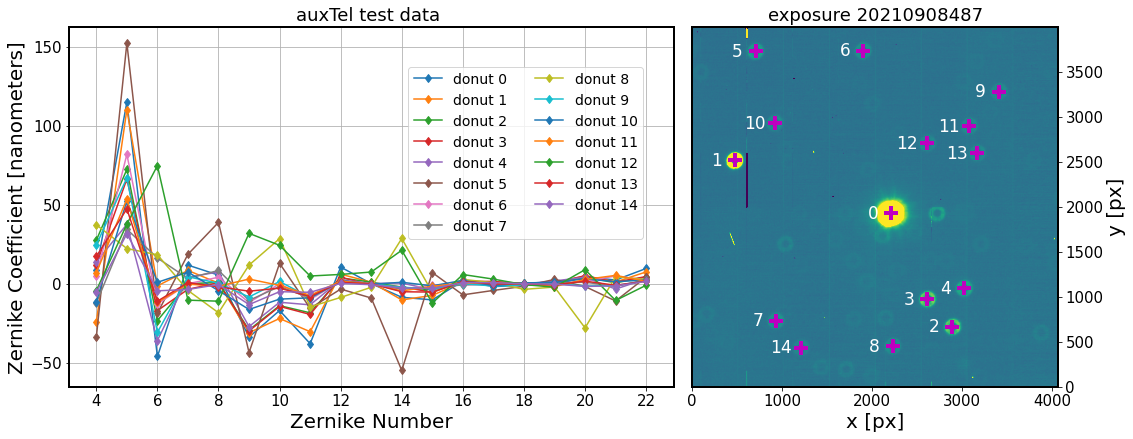

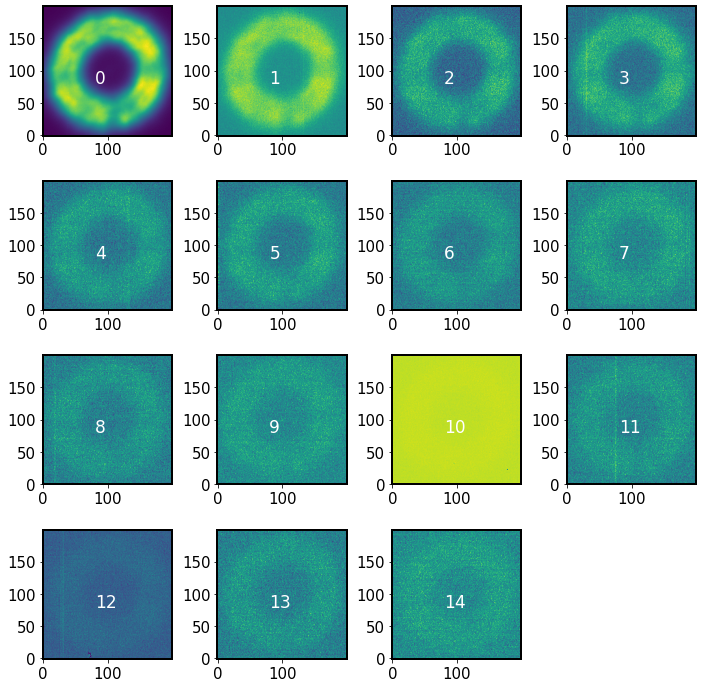

In [66]:
%matplotlib inline
fig = plt.figure(figsize=(14, 5))
zk,don = pt.get_zernikes_donuts_from_pickle('zerDic_2021090800487_extra.npy')
exposure = pt.get_postisr_from_butler('/repo/main/', 'u/scichris/Latiss/postISRex', 2021090800487)
pt.plot_raw_zernikes(zk, fig=fig)
pt.plot_donut_locations(exposure, don, fig=fig)
pt.plot_donut_stamps(don)



# 2 Run Zernike estimation using donut template fitting  to get the source catalog <a id='template'></a>
[Go to table of contents](#toc)

Only the defocal images are used, and donut template fitting provides the source catalog. The WCS information is not employed in finding sources, so accuracy of WCS attached to exposure is not relevant. 

## 2.1 Load the raw defocal images, do the ISR <a id='loadDefocal'></a>
[Go to table of contents](#toc)


Same as above -  [preview the raws](#raws) and [run the ISR](#isr). Show the postISR:
 



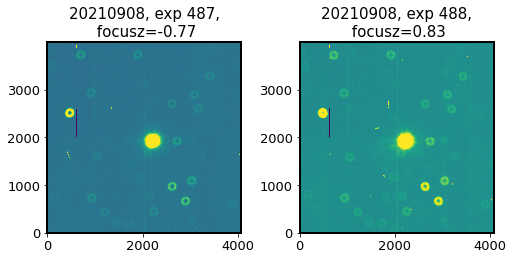

In [25]:
pt.preview_exposures(year_month_day='20210908', exp_start=487, exp_end=489,
                    dataset_ref_or_type='postISRCCD',
                    collection='u/scichris/Latiss/postISRex')

## 2.2 Find sources with  donut template fitting and run Zernike estimation <a id='fitDonuts'></a>
[Go to table of contents](#toc)

In [2]:
%matplotlib inline

def fit_zernikes(donutDetectTask,estimateZernikeTask,
                 expIntra, expExtra, 
                 yearMonthDay,
                 collection, 
                 use_extra=False):
    # load the intra and extra-focal exposures 
    exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{yearMonthDay}00{expIntra}')
                                                }, collections=[collection])

    exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{yearMonthDay}00{expExtra}')
                                                }, collections=[collection])
    camera = butler.get("camera",dataId={"instrument": "LATISS"}, 
                        collections=[collection],)
    
    # find donuts from one of the exposures
    if use_extra:
        exposure = copy(exposure_extra)
    else:
        exposure = copy(exposure_intra)
        
    donutCatalog = donutDetectTask.run(exposure)
    donutCat = donutCatalog.donutCatalog

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra ]
    zernikeOutput = estimateZernikeTask.run(exposure_pair, [donutCat], camera)

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{yearMonthDay}00{expIntra}_{expExtra}_n.npy'
    np.save(fname,zernikes, )
    print(f'Stored the results as {fname} ')



Initialize estimate Zernike task, and run Zk fitting:

In [3]:
donutDetectConfig = GenerateDonutDirectDetectTaskConfig(donutTemplateSize = 200,
                                            instName = 'auxTel',
                                            opticalModel = 'onAxis',
                                            peakThreshold = 0.99,
                                            binaryChoice = 'deblend') # adaptative image thresholding
donutDetectTask = GenerateDonutDirectDetectTask(config=donutDetectConfig)


estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                         donutTemplateSize=200,
                                                         opticalModel='onAxis')
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)

# initialize the butler
butler = dafButler.Butler('/repo/main/')

fit_zernikes(donutDetectTask, estimateZernikeTask, expIntra=487, expExtra=488, yearMonthDay='20210908',
             collection='u/scichris/Latiss/postISRex',)


Stored the results as zerDic_2021090800487_488_n.npy 


Plot the results:

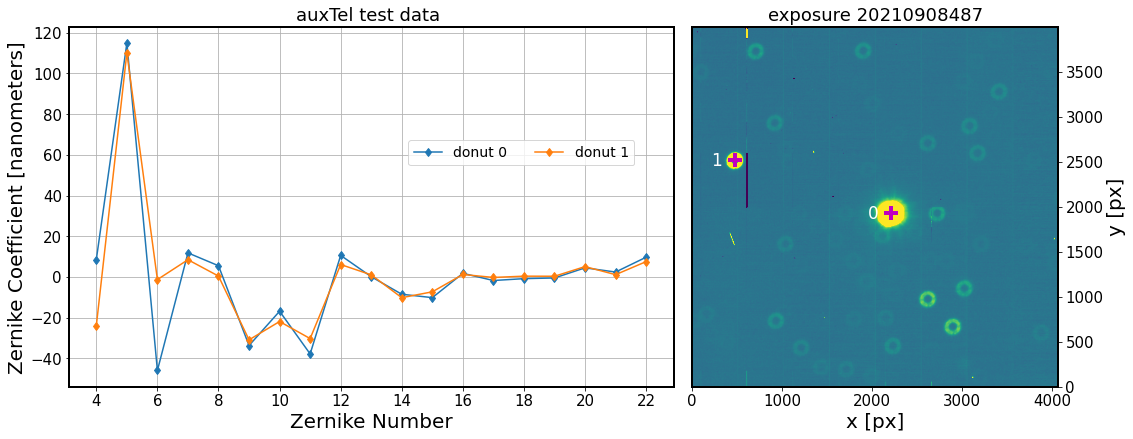

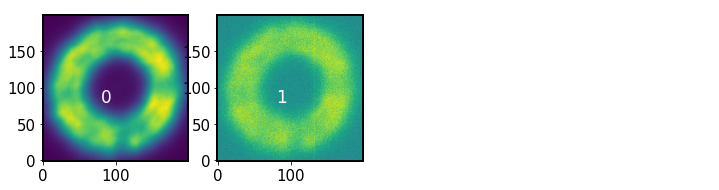

In [46]:
%matplotlib inline
fig = plt.figure(figsize=(14, 5))
zk,don = pt.get_zernikes_donuts_from_pickle('zerDic_2021090800487_488_n.npy')
exposure = pt.get_postisr_from_butler('/repo/main/', 'u/scichris/Latiss/postISRex1', 2021090800487)
pt.plot_raw_zernikes(zk, fig=fig)
pt.plot_donut_locations(exposure, don, fig=fig)
pt.plot_donut_stamps(don)

# 3 Everything as a pipetask <a id='pipetask'></a>
[Go to table of contents](#toc)

The WCS example above could not be run using the pipeline because the initial WCS guess in `GenerateDonutCatalogWcsTask.py` uses [WCS attached to the exposure](https://github.com/lsst-ts/ts_wep/blob/abd15793e7e0f0484de03661caf4c1783e78a24f/python/lsst/ts/wep/task/GenerateDonutCatalogWcsTask.py#L240), which for auxTel may not be as close as needed for astrometry to converge (rotation < 6 degrees).

Regardless of the accuracy of the WCS attached to the auxTel exposure, the `GenerateDonutDirectDetectTask` can be used to detect donuts via template fitting. 

Once the donut catalog is provided via either of these tasks, the `EstimateZernikesLatissTask` can use that to calculate Zernikes and store everything as a pipetask structure. 

To run everything as pipetask one uses a `yaml` file that contains configuration for all employed tasks. For instance,
to analyze the example data from this notebook we could use a [file very similar to the ts_wep test config files](https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testLatissPipeline.yaml) 

    description: auxTel ISR--> donut selection--> Zernike estimation pipeline
    instrument: lsst.obs.lsst.Latiss
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'
      generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.GenerateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutTemplateSize: 200
          removeBlends: True
          instName: 'auxTel'
          opticalModel: 'onAxis'
      estimateZernikesLatissTask:
        class: lsst.ts.wep.task.EstimateZernikesLatissTask.EstimateZernikesLatissTask
        config:
          # And here we specify the configuration settings
          donutTemplateSize: 200
          donutStampSize: 200
          initialCutoutPadding: 40
          instName: 'auxTel'
          opticalModel: 'onAxis'
          
          
Then the entire pipetask can be run with 

    pipetask run  --data-query "exposure IN (2021090800487,2021090800488) AND instrument='LATISS' AND visit_system=0" -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib  --output u/$USER/Latiss/postISRex1 --pipeline /project/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testLatissPipeline.yaml  --register-dataset-types
    

I use a function that employs these data products to plot the combined illustration:

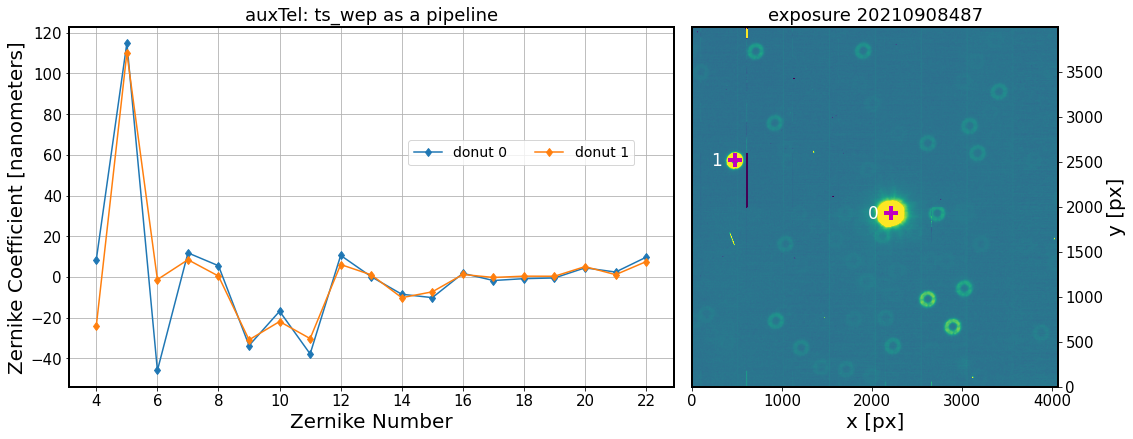

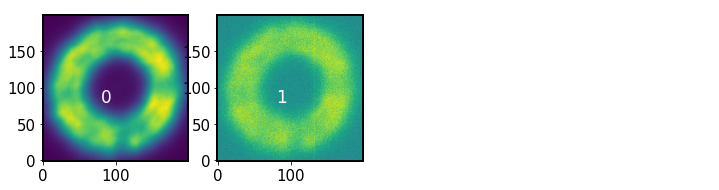

In [64]:
%matplotlib inline
fig = plt.figure(figsize=(14, 5))
zk, don, exposure = pt. get_zernikes_donuts_postisr_from_butler('/repo/main/', collection='u/scichris/Latiss/postISRex2',
                                                           instrument='LATISS',  detector=0)
pt.plot_raw_zernikes(zk, fig=fig, title='auxTel: ts_wep as a pipeline')
pt.plot_donut_locations(exposure, don, fig=fig)
pt.plot_donut_stamps(don)

# 4 Summary and conclusion <a id='summary'></a>
[Go to table of contents](#toc)

There are drawbacks to both methods we use to select sources.  

First, the [method detecting sources](#detection) in the in-focus image using `sourceDetectionTask` relies on provided PSF (since PSF characterization is lacking), and on set detection thresholds (in particular, `configDetection.thresholdValue` and `configDetection.minPixels` ). Setting these to be too low may result in eg. an error in that all pixels are masked and background cannot be estimated. 

Second, the [method of template fitting](#fitDonuts) to detect defocal donuts using  `DonutDetector` `detectDonuts` depends on the settings passed therein, consisting of `blendRadius` in pixels, and `peakThreshold`. We also made a choice to remove the `blended` donuts to clean up the catalog. This method works well when required  to detect a few brightest donuts in the image. However, if it is  important to use as many donuts as possible, then it may be easier to select them using a magnitude cut  on the reference star catalog used in the first method.